# Prep

* import tf.models
* install relevant packages 
* import binbag dataset
* define helper functions


In [1]:
# !pip -q install -U --pre tensorflow=="2.*"
!pip -q install tf_slim
!pip -q install pycocotools

     |████████████████████████████████| 358kB 3.4MB/s 


In [2]:
# Import tensorflow.models into the current directory
import os 
import pathlib
import sys

if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('...')
elif not pathlib.Path('models').exists():
  print('Downloading from github ... ')
  !git clone --depth 1 https://github.com/tensorflow/models

os.environ['PYTHONPATH'] += ":/content/models"
sys.path.append("/content/models")

Cloning into 'models'...
remote: Enumerating objects: 1919, done.
remote: Counting objects: 100% (1919/1919), done.
remote: Compressing objects: 100% (1672/1672), done.
remote: Total 1919 (delta 444), reused 780 (delta 229), pack-reused 0
Receiving objects: 100% (1919/1919), 51.33 MiB | 29.12 MiB/s, done.
Resolving deltas: 100% (444/444), done.


In [3]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.

In [4]:
%%bash 
cd models/research
pip -q install .

In [5]:
# Download data from drive into cwd

if 'Data' not in os.listdir():
  !cp "/content/drive/My Drive/ML/SEI project/Image Detection/Data/med_res.zip" .
  !unzip -q med_res.zip -d Data
  # Remove the zip file 
  !rm med_res.zip 

In [6]:
import matplotlib
import matplotlib.pyplot as plt

import os
import shutil
import json
import random
import re
import io
import imageio
import cv2
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline


In [7]:
# Helper functions 

def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Load images into numpy arrays 
def image_to_np(dir, w, h):
  output = []
  for i, file in enumerate(os.listdir(dir)):
    img = load_image_into_numpy_array(dir + file)
    res = cv2.resize(img, dsize=(w, h), interpolation=cv2.INTER_CUBIC)
    output.append(res)
  return output

# Utilizes the visualization_utils
def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None,
                    threshold = 0.8):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=threshold)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)
  
def split_data(SOURCE, TRAIN_DIR, TEST_DIR, SPLIT_PERCENT, seed = False, FILENAMES=None):

  # Get a list of image names

  if FILENAMES == None:
    files = []
    for filename in os.listdir(SOURCE):
        filepath = SOURCE + filename
        if filepath.endswith('.jpg'):
            files.append(filename)
  else:
    files = FILENAMES

  # Define test and train length
  train_length = int(len(files) * SPLIT_PERCENT)
  test_length = int(len(files)-train_length)

  # Shuffle and split
  if seed:
    random.seed(1)
  shuffled_set = random.sample(files, len(files))
  training_set = shuffled_set[0:train_length]
  testing_set = shuffled_set[-test_length:]

  # move the files
  for filename in training_set:
      os.replace(SOURCE+filename, TRAIN_DIR + filename)
      # shutil.copyfile(SOURCE+filename, TRAIN_DIR+filename)
  for filename in testing_set:
      os.replace(SOURCE+filename, TEST_DIR + filename)
      # shutil.copyfile(SOURCE+filename, TEST_DIR+filename)


# Split data, load images and labels


In [8]:
# Split data into train and test folders

def extract(label, category):
  if label[category] is not None:
    return np.array(label[category])

current_dir = os.getcwd()
image_path = os.path.join(current_dir, 'Data/med_res/images')
label_path = os.path.join(current_dir, 'Data/med_res/bboxes')

label_names = {1: 'black bag waste', 
               2: 'tyres',
               3: 'mattresses',
               4: 'furniture/household',
               5: 'gas bottles/cyclinders',
               6: 'fire extinguishers',
               7: 'WEEE'}

valid_jpgs = []

# Select only samples that contain classes from above:
for filepath in os.listdir(image_path):
  filename = filepath.split('/')[-1]
  if filename.endswith('.jpg'):
    json_file = os.path.join(label_path, filename[:-4]+'_bboxs.json')
    with open(json_file, 'r') as file:
      annotation = json.load(file)
      filtered_annotation = np.array([extract(annotation, label_names[i]) for i in label_names])
      for Class in filtered_annotation:
        # Only append if not empty
        if Class is not None:
          valid_jpgs.append(filename)
          break
        # print(annotation[Class])

print(len(os.listdir(image_path)))
print(len(valid_jpgs))

try: 
  os.mkdir(image_path + '/train')
  os.mkdir(image_path + '/test')
  print('Created train and test directories')
except:
  pass

train_dir = os.path.join(image_path, 'train/')
test_dir = os.path.join(image_path, 'test/')

# Execute moving files
try:
  split_data(image_path+'/', train_dir, test_dir, 0.95, seed=True, FILENAMES = valid_jpgs)
except OSError:
  print('error raised')
  pass

print('train folder: {}, test folder: {}'.format(len(os.listdir(train_dir)), len(os.listdir(test_dir))))

222
214
Created train and test directories
train folder: 203, test folder: 11


In [9]:
# Load label json files into numpy arrays 

def extract(label, category):
  if label[category] is not None:
    return np.array(label[category])

def json_to_np(dir):
  output_boxes = []
  output_classes = []
  for i, file in enumerate(os.listdir(dir)):
  #     # Get name of the file
      label_file = os.path.join(label_path, file[:-4]+'_bboxs.json')
      with open(label_file, 'r') as file:
        label = json.load(file)

      categories = np.array([extract(label, label_names[i]) for i in label_names])

      boxes = np.array([0, 0, 0, 0])
      classes = np.array([])

      for index, category in enumerate(categories):
        if category is not None:
          boxes = np.vstack([boxes, category])
          classes = np.append(classes, np.array([int(index+1)]*len(category)))
    
      output_boxes.append(boxes[1:])
      output_classes.append(classes.astype('int32'))

  return output_boxes, output_classes

y_train_boxes, y_train_classes = json_to_np(train_dir)
y_test_boxes, y_test_classes = json_to_np(test_dir)


In [10]:
# Normalize the labels 

# width: 420, height: 312
# Data format right now: [xmin, ymin, xmax, ymax]
# Target format         : [ymin, xmin, ymax, xmax]

orig_width = 840
orig_height = 624

target_width = orig_width
target_height = orig_height

def normalize_boxes(labels, width, height):
  for label in labels:
    for box in label:
      box[0] /= width
      box[2] /= width
      box[1] /= height
      box[3] /= height
      box[0], box[1], box[2], box[3] = box[1], box[0], box[3], box[2]
  return labels

y_train_boxes = normalize_boxes(y_train_boxes, orig_width, orig_height)
y_test_boxes = normalize_boxes(y_test_boxes, orig_width, orig_height)

print(y_test_boxes[0])

[[0.23076923 0.24857414 0.34647436 0.36858365]
 [0.31410256 0.21554183 0.57403846 0.41302281]
 [0.55288462 0.10408745 0.87884615 0.41896388]
 [0.37211538 0.39092205 0.52179487 0.56939163]
 [0.10032051 0.54942966 0.27596154 0.69557985]
 [0.64391026 0.62452471 0.7849359  0.72409696]]


In [11]:
x_train_np = image_to_np(train_dir, target_width, target_height)
print(f'Appended and resized {len(x_train_np)} training images')

x_test_np = image_to_np(test_dir, target_width, target_height)
print(f'Appended and resized {len(x_test_np)} training images')

Appended and resized 203 training images
Appended and resized 11 training images


In [12]:
# Prepping data, converting np arrays into tensors 
# Note: this needs to be updated for multi-class

def np_to_tensors(image_nps, box_nps, class_nps):
  image_tensors = []
  box_tensors = []
  classes_one_hot_tensors = []

  for (image_np, box_np, class_np) in zip(image_nps, box_nps, class_nps):
    image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
        image_np, dtype=tf.float32), axis=0))
    box_tensors.append(tf.convert_to_tensor(box_np, dtype=tf.float32))
    zero_indexed_groundtruth_classes = tf.convert_to_tensor(class_np - label_id_offset, dtype=np.int32)
    classes_one_hot_tensors.append(tf.one_hot(
        zero_indexed_groundtruth_classes, num_classes))

  return image_tensors, box_tensors, classes_one_hot_tensors

binbag_class_id = 1
tyre_class_id = 2
matt_class_id = 3
fur_class_id = 4
gas_class_id = 5
fire_class_id = 6
WEEE_class_id = 7

num_classes = 7

category_index = {}
for i in label_names:
  category_index[i] = {'id': i, 'name': label_names[i]}

label_id_offset = 1

train_image_tensors, gt_box_tensors, gt_classes_one_hot_tensors = np_to_tensors(x_train_np, y_train_boxes, y_train_classes)
test_image_tensors, test_gt_box_tensors, test_gt_classes_one_hot_tensors = np_to_tensors(x_test_np, y_test_boxes, y_test_classes)

print('Done prepping data.')

Done prepping data.


In [14]:
# Optional: visulize images

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

plt.figure(figsize=(30, 15))
for i in range(6):
  plt.subplot(2, 3, i+1)
  plot_detections(
      x_test_np[i],
      y_test_boxes[i],
      y_test_classes[i],
      np.ones(shape=[y_test_boxes[i].shape[0]], dtype=np.float16),
      category_index)
plt.axis('off')



Output hidden; open in https://colab.research.google.com to view.

# Load Neural Network MetaArch





In [13]:
if 'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8' not in os.listdir():
  !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz 
  !tar -xf ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz
  !rm ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz
# !mv ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2020-08-14 13:41:07--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.214.128, 2607:f8b0:4001:c05::80
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.214.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20518283 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_fp 100%[===================>]  19.57M  68.4MB/s    in 0.3s    

2020-08-14 13:41:07 (68.4 MB/s) - ‘ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz’ saved [20518283/20518283]



In [14]:
# Configuring and creating the detection model (weight's are not loaded here)

num_classes = 7
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.config'
checkpoint_path = 'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt'

raw_checkpoint = checkpoint_path + '-0'

# Load pipeline config and build a detection model architecture (only need to be ran once)

configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
    model_config = model_config, is_training=True
)


In [39]:
[i.name for i in detection_model.trainable_variables]
# len(detection_model.trainable_variables)

['WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/depthwise_kernel:0',
 'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/pointwise_kernel:0',
 'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/bias:0',
 'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead/ClassPredictor/depthwise_kernel:0',
 'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead/ClassPredictor/pointwise_kernel:0',
 'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead/ClassPredictor/bias:0',
 'WeightSharedConvolutionalBoxPredictor/PredictionTower/conv2d_0/depthwise_kernel:0',
 'WeightSharedConvolutionalBoxPredictor/PredictionTower/conv2d_0/pointwise_kernel:0',
 'WeightSharedConvolutionalBoxPredictor/PredictionTower/conv2d_0/BatchNorm/feature_0/gamma:0',
 'WeightSharedConvolutionalBoxPredictor/PredictionTower/conv2d_0/BatchNorm/feature_0/beta:0',
 'WeightS

In [15]:
# Restore weights (original weights)

def restore_weights(ckpt_path, restore_all=True):

  print(f'restoring weights from {str(ckpt_path)}')

  if restore_all:
    ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
    ckpt.restore(ckpt_path).expect_partial()
  
  else:
    fake_box_predictor = tf.compat.v2.train.Checkpoint(
      _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
      _box_prediction_head=detection_model._box_predictor._box_prediction_head
      )

    fake_model = tf.compat.v2.train.Checkpoint(
                _feature_extractor=detection_model._feature_extractor,
                _box_predictor=fake_box_predictor)
  
    ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
    ckpt.restore(ckpt_path).expect_partial()

  # Run model through a dummy image so that variables are created
  image, shapes = detection_model.preprocess(tf.zeros([1, target_height, target_width, 3]))
  prediction_dict = detection_model.predict(image, shapes)
  _ = detection_model.postprocess(prediction_dict, shapes)
  print('Weights restored!')

  return ckpt

# Initialize ckpt
ckpt = restore_weights(raw_checkpoint, restore_all=False)

restoring weights from ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-0
Weights restored!


# Training


## Useful Functions

### Step Function


In [18]:
# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list,
                    backprop = True):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(len(image_tensors) * [[target_height, target_width, 3]], dtype=tf.int32)

    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)

    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)

      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']

      if backprop:
        gradients = tape.gradient(total_loss, vars_to_fine_tune)
        optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))

    return total_loss

  return train_step_fn

### Variable extraction function


In [19]:
def get_variables(prefixes_to_train):
  trainable_variables = detection_model.trainable_variables
  to_fine_tune = []
  for var in trainable_variables:
    if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
      to_fine_tune.append(var)
  return to_fine_tune

  # prefixes_to_train = [
  # 'WeightSharedConvolutionalBoxPredictor']
  # prefixes_to_train = [
  #   'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  #   'WeightSConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']

### Train function

In [20]:
# Flip box
def flip_box_left_right(boxes):
  tempboxes = boxes.numpy()
  for i in range(len(tempboxes)):
    tempboxes[i][1], tempboxes[i][3] = 1 - tempboxes[i][3], 1 - tempboxes[i][1]
    # tempboxes[i][3] = 1 - tempboxes[i][1]
  
  return tf.convert_to_tensor(tempboxes, dtype=tf.float32)

# print(gt_box_tensors[0])
# print(flip_box_left_right(gt_box_tensors[0]))

# # plot_detections(
# #       tf.image.flip_left_right(train_image_tensors[0])[0].numpy().astype('int'),
# #       flip_box_left_right(gt_box_tensors[0]).numpy(),
# #       y_train_classes[0],
# #       np.ones(shape=[y_test_boxes[0].shape[0]], dtype=np.float16),
# #       category_index)

# plot_detections(
#     train_image_tensors[0][0].numpy().astype('int'),
#     gt_box_tensors[0].numpy(),
#     y_train_classes[0],
#     np.ones(shape=[y_train_boxes[0].shape[0]], dtype=np.float16),
#     category_index)

# # plt.imshow(tf.image.flip_left_right(train_image_tensors[0])[0].numpy()/255)

# print(train_image_tensors[0][0][1])
# print(tf.image.flip_left_right(train_image_tensors[0])[0][1])

In [21]:
def train(epochs, batch_size, train_step_fn, flip_ratio = 0.2):
  '''
    Performs training given epoch and batch size 

    Note: this function does not generalize, neither x_train_np or labels are passed
    as arguments
  '''

  # tf.keras.backend.set_learning_phase(True)

  num_batches = (len(x_train_np) // batch_size)

  print('Started fine-tuning!', flush=True)
  for e in range(epochs):

    epoch_loss = 0

    all_keys = list(range(len(x_train_np)))
    random.shuffle(all_keys)

    cv_loss = train_step_fn(test_image_tensors, test_gt_box_tensors, test_gt_classes_one_hot_tensors, backprop=False)

    for i in range(num_batches):

      # Grab keys for a random subset of examples
      example_keys = all_keys[(i*batch_size):((i+1)*batch_size)]
      # grab x and y using keys 
      gt_boxes_list, gt_classes_list, image_tensors = [], [], []
      for key in example_keys:
        if random.random() > flip_ratio:
          gt_boxes_list.append(gt_box_tensors[key])
          image_tensors.append(train_image_tensors[key])
        else:
          gt_boxes_list.append(flip_box_left_right(gt_box_tensors[key]))
          image_tensors.append(tf.image.flip_left_right(train_image_tensors[key]))
          
        gt_classes_list.append(gt_classes_one_hot_tensors[key])

      # gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
      # gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
      # image_tensors = [train_image_tensors[key] for key in example_keys]

      # Training step (forward pass + backwards pass)
      total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)
      epoch_loss += total_loss.numpy()

    epoch_loss /= num_batches
    
    print(f'epoch {e+1} of {epochs}, loss= {epoch_loss}, cv_loss = {cv_loss.numpy()}')
  
  cv_loss = train_step_fn(test_image_tensors, test_gt_box_tensors, test_gt_classes_one_hot_tensors, backprop=False)

  print(f'final cv_loss: {cv_loss}')
  print('Done fine-tuning!')

## Save an untuned instance before training


In [22]:
untuned_checkpoint = ckpt.save(checkpoint_path+'-untuned') 
# untuned_checkpoint = 'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-untuned-52'

In [23]:
# Optional - load
ckpt = restore_weights(untuned_checkpoint, restore_all = True)

restoring weights from ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-untuned-52
Weights restored!


## Training top


### Select top


In [25]:
# SELECT THE TOP LAYERS, and set up the training
tf.keras.backend.clear_session()

# Restore weights
# ckpt = restore_weights(raw_checkpoint, restore_all=False)
try: 
  ckpt = restore_weights(untuned_checkpoint, restore_all = True)
except:
  print('could not restore untuned weights')
  pass

# Hyper parameters
epochs = 70
batch_size = 5
num_batches = (len(x_train_np) // batch_size)

# Define Optimizer
optimizer = tf.keras.optimizers.Adam()

# Select variables in top layers to fine-tune.
to_fine_tune = get_variables(['WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
                              'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead'])

# Get step function
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

# Run on CV:
test_loss = train_step_fn(test_image_tensors, test_gt_box_tensors, test_gt_classes_one_hot_tensors, backprop=False)
print(test_loss.numpy())

# Untuned - 1.4880947

restoring weights from ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-untuned-52
Weights restored!
1.4880947


### Train

In [26]:
train(epochs, batch_size, train_step_fn, flip_ratio = 0.2)

Started fine-tuning!
epoch 1 of 70, loss= 1.3944946825504303, cv_loss = 1.488094687461853
epoch 2 of 70, loss= 1.1633072197437286, cv_loss = 1.2427825927734375
epoch 3 of 70, loss= 1.0724232718348503, cv_loss = 1.0492384433746338
epoch 4 of 70, loss= 1.0391951724886894, cv_loss = 0.9857621192932129
epoch 5 of 70, loss= 1.017427395284176, cv_loss = 0.9397131204605103
epoch 6 of 70, loss= 0.9806830629706382, cv_loss = 0.9516592621803284
epoch 7 of 70, loss= 0.9583639889955521, cv_loss = 0.9222139120101929
epoch 8 of 70, loss= 0.9496773257851601, cv_loss = 0.8977837562561035
epoch 9 of 70, loss= 0.937264934182167, cv_loss = 0.8902236223220825
epoch 10 of 70, loss= 0.9197607681155204, cv_loss = 0.8865281343460083
epoch 11 of 70, loss= 0.9136183068156243, cv_loss = 0.8895707130432129
epoch 12 of 70, loss= 0.8962510153651237, cv_loss = 0.8755817413330078
epoch 13 of 70, loss= 0.902262419462204, cv_loss = 0.8769941329956055
epoch 14 of 70, loss= 0.8816049098968506, cv_loss = 0.867659687995910

### Save trained checkpoint

In [27]:
top_trained_checkpoint = ckpt.save(checkpoint_path+'-top')
# top_trained_checkpoint = checkpoint_path + '-top_trained-55'
print(top_trained_checkpoint)

ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-top-53


## Train Box Predictor

In [28]:
# Restore weights
restore_weights(top_trained_checkpoint, restore_all=True)

restoring weights from ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-top-53
Weights restored!


In [29]:
# Select box predictor variables to train

# Hyperparameters
epochs = 25
batch_size = 5
num_batches = (len(x_train_np) // batch_size)

# optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)

# Select variables in top layers to fine-tune.
to_fine_tune = get_variables(['WeightSharedConvolutionalBoxPredictor'])

# Get step function
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

# loss = train_step_fn(train_image_tensors, gt_box_tensors, gt_classes_one_hot_tensors, backprop=False)
cv_loss = train_step_fn(test_image_tensors, test_gt_box_tensors, test_gt_classes_one_hot_tensors, backprop=False)

# print(loss.numpy())
print(cv_loss.numpy())

# top-trained:0.8682906

0.8363242


### Train

In [30]:
train(epochs, batch_size, train_step_fn)

Started fine-tuning!
epoch 1 of 25, loss= 0.8195172756910324, cv_loss = 0.8363242149353027
epoch 2 of 25, loss= 0.7930885225534439, cv_loss = 0.8515687584877014
epoch 3 of 25, loss= 0.7928942248225213, cv_loss = 0.8205087184906006
epoch 4 of 25, loss= 0.7857228696346283, cv_loss = 0.8088381886482239
epoch 5 of 25, loss= 0.7631273791193962, cv_loss = 0.8289412260055542
epoch 6 of 25, loss= 0.7797727301716805, cv_loss = 0.8074915409088135
epoch 7 of 25, loss= 0.7550331860780716, cv_loss = 0.8063300251960754
epoch 8 of 25, loss= 0.7624768629670143, cv_loss = 0.8197223544120789
epoch 9 of 25, loss= 0.7598129644989967, cv_loss = 0.7926384806632996
epoch 10 of 25, loss= 0.7369193285703659, cv_loss = 0.799895167350769
epoch 11 of 25, loss= 0.7575258046388627, cv_loss = 0.7955822944641113
epoch 12 of 25, loss= 0.7349282428622246, cv_loss = 0.7770509123802185
epoch 13 of 25, loss= 0.7447205558419228, cv_loss = 0.7997607588768005
epoch 14 of 25, loss= 0.7347288444638252, cv_loss = 0.793764114379

In [31]:
big_top_path = ckpt.save(checkpoint_path+'-boxPredictor')

## Train entire model

In [32]:
restore_weights(big_top_path, restore_all=True)

restoring weights from ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-boxPredictor-54
Weights restored!


In [33]:
# Select all variables to train

# Hyperparameters
epochs = 10
batch_size = 5
num_batches = (len(x_train_np) // batch_size)

# optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001)

# Select variables in top layers to fine-tune.
# to_fine_tune = get_variables(['WeightSharedConvolutionalBoxPredictor'])
to_fine_tune = detection_model.trainable_variables

# Get step function
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

# loss = train_step_fn(train_image_tensors, gt_box_tensors, gt_classes_one_hot_tensors, backprop=False)
cv_loss = train_step_fn(test_image_tensors, test_gt_box_tensors, test_gt_classes_one_hot_tensors, backprop=False)

# print(loss.numpy())
print(cv_loss.numpy())

# big-top-trained: 0.8113712

0.7803271


In [34]:
train(epochs, batch_size, train_step_fn)

Started fine-tuning!
epoch 1 of 10, loss= 0.690944992005825, cv_loss = 0.7803270816802979
epoch 2 of 10, loss= 0.6379481539130211, cv_loss = 0.7281805872917175
epoch 3 of 10, loss= 0.607539239525795, cv_loss = 0.7023891806602478
epoch 4 of 10, loss= 0.5791241317987442, cv_loss = 0.6935861706733704
epoch 5 of 10, loss= 0.5336039952933789, cv_loss = 0.6698310375213623
epoch 6 of 10, loss= 0.517171835154295, cv_loss = 0.6640177369117737
epoch 7 of 10, loss= 0.5100434795022011, cv_loss = 0.6724644303321838
epoch 8 of 10, loss= 0.4869787760078907, cv_loss = 0.6776779890060425
epoch 9 of 10, loss= 0.46280235052108765, cv_loss = 0.6546445488929749
epoch 10 of 10, loss= 0.45415633395314214, cv_loss = 0.6638144254684448
final cv_loss: 0.664741039276123
Done fine-tuning!


In [35]:
entire_model_path = ckpt.save(checkpoint_path+'-all-trained')

In [36]:
restore_weights(entire_model_path, restore_all=True)

cv_loss = train_step_fn(test_image_tensors, test_gt_box_tensors, test_gt_classes_one_hot_tensors, backprop=False)

print(cv_loss)

restoring weights from ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-all-trained-55
Weights restored!
tf.Tensor(0.66474104, shape=(), dtype=float32)


## Optional: export model to drive

In [37]:
model_to_export = ckpt.save('export/ckpt')

In [38]:
%%bash
cd 'export'
ls
zip -r seven_classes_4.zip . -x ".*" -x "__MACOSX"
# cp 'export/seven_classes.zip' '/content/drive/My Drive/ML'

checkpoint
ckpt-56.data-00000-of-00001
ckpt-56.index
  adding: ckpt-56.data-00000-of-00001 (deflated 8%)
  adding: checkpoint (deflated 38%)
  adding: ckpt-56.index (deflated 80%)


In [39]:
cp 'export/seven_classes_4.zip' '/content/drive/My Drive/ML'

# Test


## Optional: Load from trained model

In [16]:
# !cp '/content/drive/My Drive/ML/checkpoints2.zip' .
!cp '/content/drive/My Drive/ML/seven_classes_4.zip' .
!unzip -q seven_classes_4.zip
# Remove the zip file 
!rm seven_classes_4.zip 

In [17]:
restore_weights('ckpt-56')

restoring weights from ckpt-56
Weights restored!


### Detect Function


In [18]:
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)


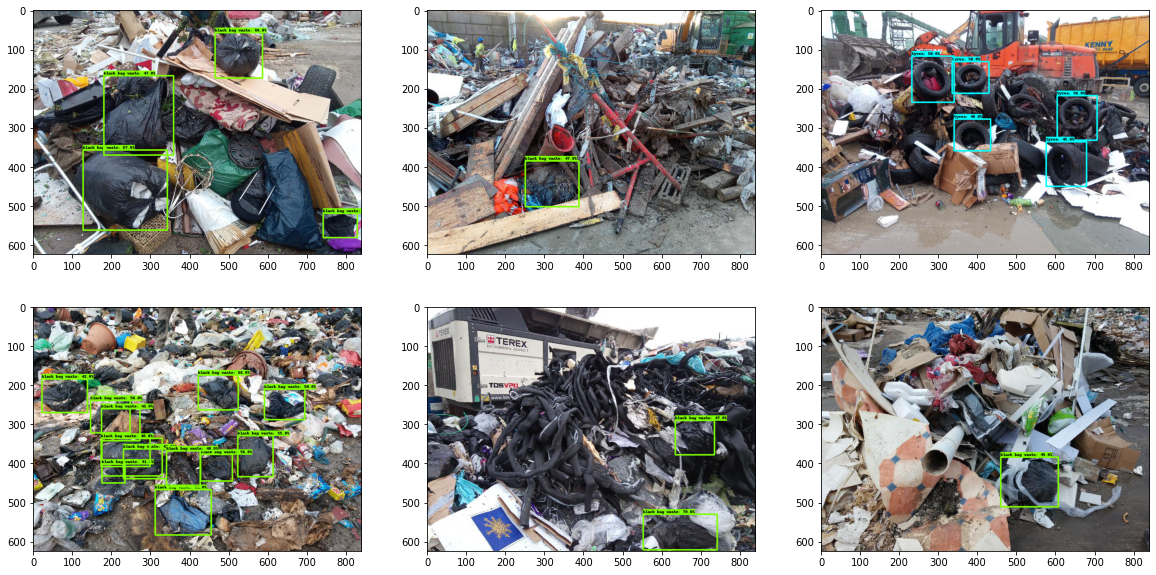

In [19]:
plt.figure(figsize=(20,10))
for i in range(6):
  offset = 0
  input_tensor = tf.convert_to_tensor(np.expand_dims(x_test_np[i+offset], axis=0), dtype=tf.float32)
  detection = detect(input_tensor)
  plt.subplot(2, 3, i+1)
  plot_detections(
      x_test_np[i+offset],
      detection['detection_boxes'][0].numpy(),
      detection['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detection['detection_scores'][0].numpy(),
      category_index,
      threshold = 0.4)
plt.show()



In [ ]:
tempdir = '/content/drive/My Drive/ML/'
!mv tempdir /content/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-all-trained-58.data-00001-of-00002
# !cp /content/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-all-trained-58.data-00001-of-00002 '/content/drive/My Drive/ML/'

mv: cannot stat '/content/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-all-trained-58.data-00001-of-00002': No such file or directory


# Temporary block 

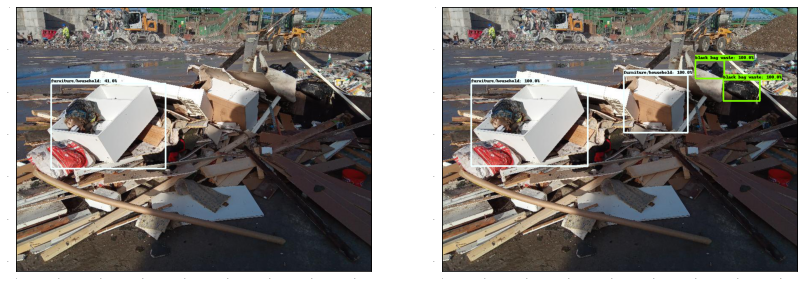

In [52]:
idx = 10

detection = detect(test_image_tensors[idx])

plt.subplot(1, 2, 1)
plot_detections(
      x_test_np[idx],
      detection['detection_boxes'][0].numpy(),
      detection['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detection['detection_scores'][0].numpy(),
      category_index,
      threshold = 0.4)

plt.subplot(1, 2, 2)
plot_detections(
      x_test_np[idx],
      y_test_boxes[idx],
      y_test_classes[idx],
      np.ones(shape=[y_test_classes[idx].shape[0]], dtype=np.float16),
      category_index)

In [20]:
# Calculate IOU 
  # There is one IOU value per box (in prediction)
  # Match to Ground truth or none

# Ground truth boxes: m x 4 np array 
# Detection boxes: 1 x 100 x 4 tensor 

# [ymin, xmin, ymax, xmax]

# xi1 = maximum of the x1 coordinates of the two boxes
# yi1 = maximum of the y1 coordinates of the two boxes
# xi2 = minimum of the x2 coordinates of the two boxes
# yi2 = minimum of the y2 coordinates of the two boxes

def iou(box1, box2):
    """Implement the intersection over union (IoU) between box1 and box2
    
    Arguments:
    box1 -- first box, list object with coordinates (box1_x1, box1_y1, box1_x2, box_1_y2)
    box2 -- second box, list object with coordinates (box2_x1, box2_y1, box2_x2, box2_y2)
    """

    # Assign variable names to coordinates for clarity
    (box1_y1, box1_x1, box1_y2, box1_x2) = box1
    (box2_y1, box2_x1, box2_y2, box2_x2) = box2
    
    # Calculate the (yi1, xi1, yi2, xi2) coordinates of the intersection of box1 and box2
    xi1 = np.maximum(box1_x1, box2_x1)
    yi1 = np.maximum(box1_y1, box2_y1)
    xi2 = np.minimum(box1_x2, box2_x2)
    yi2 = np.minimum(box1_y2, box2_y2)
    inter_width = yi2 - yi1
    inter_height = xi2 - xi1
    if inter_width < 0 or inter_height < 0:
        return 0
    inter_area = inter_width * inter_height

    # Calculate the Union area
    box1_area = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
    box2_area = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)
    union_area = (box1_area + box2_area) - inter_area
    
    # compute the IoU
    iou = inter_area / union_area
    
    return iou

def filter_from_score(scores, classes, boxes, threshold):
  for i, score in enumerate(scores):
    if score < threshold:
      break
  return scores[:i], classes[:i], boxes[:i]

def get_ious(detected_boxes, detected_classes, gt_boxes, gt_classes):

  '''
    boxes: [ymin, xmin, ymax, xmax]
  '''

  ious_arr = []
  detected_which = []
  hash_table = [None] * len(gt_boxes)

  for i, (box, label) in enumerate(zip(detected_boxes, detected_classes)):
    max_iou = 0
    detected_which.append(-1)
    for j, (gt_box, gt_class) in enumerate(zip(gt_boxes, gt_classes)):
      if gt_class == label:
        iou_val = iou(gt_box, box)
        if iou_val > max_iou:
          max_iou = iou_val
          detected_which[i] = j
          if not hash_table[j]:
            hash_table[j] = (max_iou, i)
          else:
            if hash_table[j][0] < max_iou:
              detected_which[hash_table[j][1]] = -1
              hash_table[j] = (max_iou, i)
              
    ious_arr.append(max_iou)

  return ious_arr, detected_which

def get_tpfp(ious_arr, detected_which, iou_threshold = 0.5):

  tpfp = []
  for which, iou_val in zip(detected_which, ious_arr):
    if which < 0 or iou_val < iou_threshold:
      tpfp.append(0)
    else:
      tpfp.append(1) 
  
  return tpfp

def get_tpfp_list(detected_box_list, detected_class_list, detected_score_list, gt_box_list, gt_class_list, iou_threshold):
  '''
    Categorizes detections into a list of true positives and false positives in descending order of confidence level
  '''
  tpfp_list = []

  for idx in range(len(detected_score_list)):
    detected_boxes, detected_classes, detected_scores = detected_box_list[idx], detected_class_list[idx], detected_score_list[idx]

    gt_boxes = gt_box_list[idx]
    gt_classes = gt_class_list[idx]

    ious_arr, detected_which = get_ious(detected_boxes, detected_classes, gt_boxes, gt_classes)

    tpfp = get_tpfp(ious_arr, detected_which, iou_threshold=iou_threshold)

    tpfp_score_pairs = [(i, j) for i, j in zip(tpfp, detected_scores)]

    tpfp_list += tpfp_score_pairs
  
  return tpfp_list

def calculate_map(detected_box_list, 
                  detected_class_list, 
                  detected_score_list, 
                  gt_box_list, 
                  gt_class_list, 
                  num_of_classes,
                  iou_threshold = 0.5):
  '''
    calculates mAP, outputs precision and recall

    Inputs are filtered lists of detection boxes, classes, and confidence scores
    Detections have to be preprocessed and filtered based on confidence threshold

    detected_box_list: m x ? x 4
    detected_class_list: m x ?
    detected_score_list: m x ?

    gt_box_list: m x ?
    gt_class_list: m x ?

    where m is the number of samples
    ? because the number of detections and number of gt boxes is different for each sample
    all lists are lists of np arrays
  '''

  precision_list = []
  recall_list = []
  map_list = []

  for c in range(num_of_classes):
    class_eval = c + 1

    length = len(detected_box_list)
    detected_boxes_eval = [np.array([[0, 0, 0, 0]])]*length
    detected_classes_eval = [np.array([])]*length
    detected_scores_eval = [np.array([])]*length

    length = len(gt_class_list)
    gt_boxes_eval = [np.array([[0, 0, 0, 0]])]*length
    gt_classes_eval = [np.array([])]*length


    for i, detected_class in enumerate(detected_class_list):
      for j, Class in enumerate(detected_class):
        if Class == class_eval:
          detected_classes_eval[i] = np.append(detected_classes_eval[i], detected_class_list[i][j])
          detected_boxes_eval[i] = np.vstack([detected_boxes_eval[i], detected_box_list[i][j]])
          detected_scores_eval[i] = np.append(detected_scores_eval[i], detected_score_list[i][j])
      if detected_boxes_eval[i].shape[0] == 1:
        detected_boxes_eval[i] = np.array([])
      else:
        detected_boxes_eval[i] = detected_boxes_eval[i][1:]

    for i, gt_class in enumerate(gt_class_list):
      for j, Class in enumerate(gt_class):
        if Class == class_eval:
          gt_classes_eval[i] = np.append(gt_classes_eval[i], gt_class_list[i][j])
          gt_boxes_eval[i] = np.vstack([gt_boxes_eval[i], gt_box_list[i][j]])
      if gt_boxes_eval[i].shape[0] == 1:
        gt_boxes_eval[i] = np.array([])
      else:
        gt_boxes_eval[i] = gt_boxes_eval[i][1:]

    tpfp_list = get_tpfp_list(detected_boxes_eval, 
                              detected_classes_eval, 
                              detected_scores_eval, 
                              gt_boxes_eval, 
                              gt_classes_eval, 
                              iou_threshold=iou_threshold)
                              

    tpfp_list.sort(key=lambda tup: tup[1], reverse=True)

    precisions = []
    recalls = []
    tp = 0
    fp = 0

    total = 0
    for i in gt_boxes_eval:
      total += len(i)

    detection_total = 0
    for i in detected_boxes_eval:
      detection_total += len(i)

    for i, (tpfp, _) in enumerate(tpfp_list):
      if tpfp == 1:
        tp += 1
      else:
        fp += 1

      precision = tp/(tp+fp)
      recall = tp/total

      precisions.append(precision)
      recalls.append(recall)

    print(f'{label_names[c+1]}: {total} annotations')
    print(f'{tp} / {detection_total} correct detections \n')
    map = np.trapz(precisions, recalls)
    precision_list.append(np.array(precisions))
    recall_list.append(np.array(recalls))
    map_list.append(map)

  return precision_list, recall_list, map_list

In [21]:
detected_boxes = []
detected_classes = []
detected_scores = []

for i in range(len(y_train_classes)):
  detection = detect(train_image_tensors[i])
  detected_score, detected_class, detected_box = filter_from_score(detection['detection_scores'][0].numpy(),
                                                                  detection['detection_classes'][0].numpy()+label_id_offset,
                                                                  detection['detection_boxes'][0].numpy(),
                                                                  threshold = 0.4)
  detected_boxes.append(detected_box)
  detected_classes.append(detected_class)
  detected_scores.append(detected_score)


In [23]:
p, r, map = calculate_map(detected_boxes, 
                          detected_classes, 
                          detected_scores, 
                          y_train_boxes, 
                          y_train_classes, 
                          num_of_classes = num_classes,
                          iou_threshold = 0.5)

print(map)
sum(map)/num_classes



black bag waste: 507 annotations
314 / 423 correct detections 

tyres: 91 annotations
61 / 85 correct detections 

mattresses: 16 annotations
7 / 7 correct detections 

furniture/household: 105 annotations
42 / 59 correct detections 

gas bottles/cyclinders: 89 annotations
52 / 92 correct detections 

fire extinguishers: 46 annotations
30 / 55 correct detections 

WEEE: 18 annotations
9 / 10 correct detections 

[0.49560074385123126, 0.4706006585764523, 0.375, 0.3416031164428908, 0.2950535717767318, 0.41412867124775904, 0.39329805996472667]


0.39789783169425597

In [24]:
detected_boxes = []
detected_classes = []
detected_scores = []

for i in range(len(y_test_classes)):
  detection = detect(test_image_tensors[i])
  detected_score, detected_class, detected_box = filter_from_score(detection['detection_scores'][0].numpy(),
                                                                  detection['detection_classes'][0].numpy()+label_id_offset,
                                                                  detection['detection_boxes'][0].numpy(),
                                                                  threshold = 0.4)
  detected_boxes.append(detected_box)
  detected_classes.append(detected_class)
  detected_scores.append(detected_score)


In [26]:
p, r, map = calculate_map(detected_boxes, 
                          detected_classes, 
                          detected_scores, 
                          y_test_boxes, 
                          y_test_classes, 
                          num_of_classes = num_classes,
                          iou_threshold = 0.5)

print(map)
sum(map)/3

black bag waste: 48 annotations
18 / 29 correct detections 

tyres: 14 annotations
5 / 5 correct detections 

mattresses: 1 annotations
1 / 1 correct detections 

furniture/household: 7 annotations
1 / 2 correct detections 

gas bottles/cyclinders: 0 annotations
0 / 0 correct detections 

fire extinguishers: 0 annotations
0 / 0 correct detections 

WEEE: 0 annotations
0 / 0 correct detections 

[0.287377412256409, 0.2857142857142857, 0.0, 0.03571428571428571, 0.0, 0.0, 0.0]


0.20293532789499347

In [ ]:
# filter down to class

class_eval = 4

length = len(detected_boxes)
detected_boxes_eval = [np.array([[0, 0, 0, 0]])]*length
detected_classes_eval = [np.array([])]*length
detected_scores_eval = [np.array([])]*length

length = len(y_train_classes)
gt_boxes_eval = [np.array([[0, 0, 0, 0]])]*length
gt_classes_eval = [np.array([])]*length


for i, detected_class in enumerate(detected_classes):
  for j, Class in enumerate(detected_class):
    if Class == class_eval:
      detected_classes_eval[i] = np.append(detected_classes_eval[i], detected_classes[i][j])
      detected_boxes_eval[i] = np.vstack([detected_boxes_eval[i], detected_boxes[i][j]])
      detected_scores_eval[i] = np.append(detected_scores_eval[i], detected_scores[i][j])
  if detected_boxes_eval[i].shape[0] == 1:
    detected_boxes_eval[i] = np.array([])
  else:
    detected_boxes_eval[i] = detected_boxes_eval[i][1:]

for i, gt_class in enumerate(y_train_classes):
  for j, Class in enumerate(gt_class):
    if Class == class_eval:
      gt_classes_eval[i] = np.append(gt_classes_eval[i], y_train_classes[i][j])
      gt_boxes_eval[i] = np.vstack([gt_boxes_eval[i], y_train_boxes[i][j]])
  if gt_boxes_eval[i].shape[0] == 1:
    gt_boxes_eval[i] = np.array([])
  else:
    gt_boxes_eval[i] = gt_boxes_eval[i][1:]


total_num = 0
for thing in gt_boxes_eval:
  total_num += thing.shape[0]
total_num

# y_train_boxes[0][0]

43

In [ ]:
total_map = 0

for c in range(4):
  class_eval = c+1
  
  length = len(detected_boxes)
  detected_boxes_eval = [np.array([[0, 0, 0, 0]])]*length
  detected_classes_eval = [np.array([])]*length
  detected_scores_eval = [np.array([])]*length

  length = len(y_train_classes)
  gt_boxes_eval = [np.array([[0, 0, 0, 0]])]*length
  gt_classes_eval = [np.array([])]*length


  for i, detected_class in enumerate(detected_classes):
    for j, Class in enumerate(detected_class):
      if Class == class_eval:
        detected_classes_eval[i] = np.append(detected_classes_eval[i], detected_classes[i][j])
        detected_boxes_eval[i] = np.vstack([detected_boxes_eval[i], detected_boxes[i][j]])
        detected_scores_eval[i] = np.append(detected_scores_eval[i], detected_scores[i][j])
    if detected_boxes_eval[i].shape[0] == 1:
      detected_boxes_eval[i] = np.array([])
    else:
      detected_boxes_eval[i] = detected_boxes_eval[i][1:]

  for i, gt_class in enumerate(y_train_classes):
    for j, Class in enumerate(gt_class):
      if Class == class_eval:
        gt_classes_eval[i] = np.append(gt_classes_eval[i], y_train_classes[i][j])
        # print(y_train_boxes[i][j])
        # print(gt_boxes_eval)
        gt_boxes_eval[i] = np.vstack([gt_boxes_eval[i], y_train_boxes[i][j]])
    if gt_boxes_eval[i].shape[0] == 1:
      gt_boxes_eval[i] = np.array([])
    else:
      gt_boxes_eval[i] = gt_boxes_eval[i][1:]

  p, r, map = calculate_map(detected_boxes_eval, 
                            detected_classes_eval, 
                            detected_scores_eval, 
                            gt_boxes_eval, 
                            gt_classes_eval, 
                            iou_threshold = 0.5)
  
  total_map += map

total_map/4

total number of boxes = 128
total number of boxes = 6
total number of boxes = 3
total number of boxes = 43


0.5993901715309471